# MovieLenseTest
> test Jupyter notebooks.
- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

# 1. 데이터 불러오기

In [2]:
# !pip3 install lightfm
import pandas as pd
import numpy as np
from lightfm.data import Dataset
from scipy.io import mmwrite

# Data Load
ratings = pd.read_csv('../data/ratings.dat',sep="::",
                      names=['UserID','MovieID','Rating','Timestamp'], header=None
)

movies = pd.read_csv('../data/movies.dat',sep="::",
                      names=['MovieID','Title','Genres'], header=None, encoding='unicode_escape'
)

/var/folders/_2/9zwdysb90f1_vz3zpxqvhg5r0000gn/T/ipykernel_15117/2007681553.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('/Users/nhn/Desktop/1_dev/0_aiengine/4_data/ml-1m/ratings.dat',sep="::",
/var/folders/_2/9zwdysb90f1_vz3zpxqvhg5r0000gn/T/ipykernel_15117/2007681553.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('/Users/nhn/Desktop/1_dev/0_aiengine/4_data/ml-1m/movies.dat',sep="::",


RATINGS FILE DESCRIPTION
================================================================================

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [3]:
print(ratings.count()[0])
ratings.head()

1000209


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


MOVIES FILE DESCRIPTION
================================================================================

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

In [4]:
print(movies.count()[0])
movies.head()

3883


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# 2. 전처리

ratings_souce와 item_features_source라는 iterable 객체가 필요하다. 
먼저 전자는 LightFM Dataset class의 build_interactions 메서드의 재료로 활용되며, 
후자의 경우 build_item_features의 재료가 된다. 

In [5]:
import pandas as pd
from lightfm.data import Dataset
from scipy.io import mmwrite

ratings_source = [(ratings['UserID'][i], ratings['MovieID'][i]) for i in range(ratings.shape[0])]

item_meta = pd.merge(movies, 
                     ratings.groupby('MovieID').mean().reset_index()[['MovieID','Rating']], 
                     on='MovieID', how='left')
item_meta = item_meta.reset_index()

item_meta.Rating = item_meta.Rating.fillna(0)
item_features_source = [(item_meta['MovieID'][i],
                        [item_meta['Title'][i],
                         item_meta['Rating'][i]]) for i in range(item_meta.shape[0])]

items 와 features를 매핑 (argument로 들어가는 객체에 결측값은 없어야 합니다.)

In [6]:
item_meta[item_meta.Rating.isna()]

,index,MovieID,Title,Genres,Rating


In [7]:
item_meta[item_meta.Rating == 0]

,index,MovieID,Title,Genres,Rating
50,50,51,Guardian Angel (1994),Action|Drama|Thriller,0.0
107,107,109,Headless Body in Topless Bar (1995),Comedy,0.0
113,113,115,Happiness Is in the Field (1995),Comedy,0.0
141,141,143,Gospa (1995),Drama,0.0
281,281,284,New York Cop (1996),Action|Crime,0.0
...,...,...,...,...,...
3581,3581,3650,Anguish (Angustia) (1986),Horror,0.0
3681,3681,3750,Boricua's Bond (2000),Drama,0.0
3759,3759,3829,Mad About Mambo (2000),Comedy|Romance,0.0
3786,3786,3856,Autumn Heart (1999),Drama,0.0


In [8]:
item_meta

,index,MovieID,Title,Genres,Rating
0,0,1,Toy Story (1995),Animation|Children's|Comedy,4.146846
1,1,2,Jumanji (1995),Adventure|Children's|Fantasy,3.201141
2,2,3,Grumpier Old Men (1995),Comedy|Romance,3.016736
3,3,4,Waiting to Exhale (1995),Comedy|Drama,2.729412
4,4,5,Father of the Bride Part II (1995),Comedy,3.006757
...,...,...,...,...,...
3878,3878,3948,Meet the Parents (2000),Comedy,3.635731
3879,3879,3949,Requiem for a Dream (2000),Drama,4.115132
3880,3880,3950,Tigerland (2000),Drama,3.666667
3881,3881,3951,Two Family House (2000),Drama,3.900000


In [9]:
dataset = Dataset()
dataset.fit(users=ratings['UserID'].unique(),
            items=item_meta['MovieID'].unique(),
            item_features=item_meta[item_meta.columns[1:]].values.flatten()
            )

In [10]:
item_meta

,index,MovieID,Title,Genres,Rating
0,0,1,Toy Story (1995),Animation|Children's|Comedy,4.146846
1,1,2,Jumanji (1995),Adventure|Children's|Fantasy,3.201141
2,2,3,Grumpier Old Men (1995),Comedy|Romance,3.016736
3,3,4,Waiting to Exhale (1995),Comedy|Drama,2.729412
4,4,5,Father of the Bride Part II (1995),Comedy,3.006757
...,...,...,...,...,...
3878,3878,3948,Meet the Parents (2000),Comedy,3.635731
3879,3879,3949,Requiem for a Dream (2000),Drama,4.115132
3880,3880,3950,Tigerland (2000),Drama,3.666667
3881,3881,3951,Two Family House (2000),Drama,3.900000


build를 실행 하여 데이터셋 완성/저장 (희소행렬)

In [11]:
interactions, weights = dataset.build_interactions(ratings_source)
item_features = dataset.build_item_features(item_features_source)

# Save
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/interactions.mtx', interactions)
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/item_features.mtx', item_features)
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/weights.mtx', weights)

# 3. Hyper Parameter 최적화

- no_components, learning_rate 대상 진행
- precision 기준 가장 높은 갚을 선정

In [12]:
from lightfm import cross_validation as CV

# Split Train, Test data
train, test = CV.random_train_test_split(interactions, test_percentage=0.2)
train, test = train.tocsr().tocoo(), test.tocsr().tocoo()
train_weights = train.multiply(weights).tocoo()

In [18]:
!pip3 install hyperopt
from hyperopt import fmin, hp, tpe, Trials

# Define Search Space
trials = Trials()

epochs_list = range(3, 6)
no_components_list = range(10, 50, 10)
space = [hp.choice('epochs', epochs_list),
         hp.choice('no_components', no_components_list),
         hp.uniform('learning_rate', 0.01, 0.05)]

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 5.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.9 MB/s eta 0:00:00:00:0100:01


In [19]:
from lightfm import LightFM
from lightfm import evaluation as EVAL

# Define Objective Function
def objective(params):
    epochs, no_components, learning_rate = params

    model = LightFM(no_components=no_components,
                    learning_schedule='adagrad',
                    loss='warp',
                    learning_rate=learning_rate,
                    random_state=0)

    model.fit(interactions=train,
              item_features=item_features,
              sample_weight=train_weights,
              epochs=epochs,
              verbose=False)
    
    # 모델에 대한 k 메트릭에서 정밀도. 순위가 매겨진 결과 목록의 처음 k 위치에서 알려진 양성 비율입니다. 만점은 1.0입니다.
    test_precision = EVAL.precision_at_k(model, test, k=5, 
                                         item_features=item_features).mean()
    print("no_comp: {}, lrn_rate: {:.5f}, precision: {:.5f}".format(
      no_components, learning_rate, test_precision))
    # test_auc = auc_score(model, test, item_features=item_features).mean()
    output = -test_precision

    if np.abs(output+1) < 0.01 or output < -1.0:
        output = 0.0

    return output

In [20]:
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

no_comp: 10, lrn_rate: 0.01398, precision: 0.10053                                                                                                                                                                                                   
no_comp: 10, lrn_rate: 0.01033, precision: 0.10027                                                                                                                                                                                                   
no_comp: 20, lrn_rate: 0.04762, precision: 0.12781                                                                                                                                                                                                   
no_comp: 30, lrn_rate: 0.03004, precision: 0.12377                                                                                                                                                                                                   
no_comp: 40, lrn

In [21]:
best_params

{'epochs': 2, 'learning_rate': 0.046210081165994746, 'no_components': 3}

# 4. 결과 확인

- 코사인 유사도를 활용 동일 백터에 있는 상위 상품 추천
두 벡터가 가리키는 방향이 얼마나 유사한가
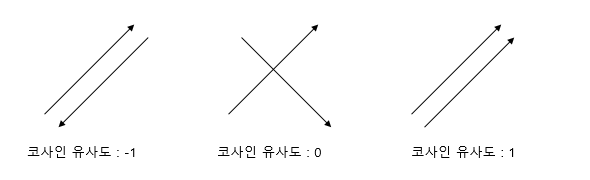

In [22]:
model = LightFM(no_components=no_components_list[best_params['no_components']],
                learning_schedule='adagrad',
                loss='warp',
                learning_rate=best_params['learning_rate'],
                random_state=0)

model.fit(interactions=train,
          item_features=item_features,
          sample_weight=train_weights,
          epochs=epochs_list[1],
          verbose=False)

EVAL.auc_score(model, test, item_features=item_features).mean()

0.9074022

In [23]:
# Find Similar Items
item_biases, item_embeddings = model.get_item_representations(features=item_features)

def make_best_items_report(item_embeddings, MovieID, num_search_items=10):
    item_id = item_meta[item_meta['MovieID'] == MovieID].index[0]

    # Cosine similarity
    scores = item_embeddings.dot(item_embeddings[item_id])  # (10000, )
    item_norms = np.linalg.norm(item_embeddings, axis=1)    # (10000, )
    item_norms[item_norms == 0] = 1e-10
    scores /= item_norms
    
    # best: score가 제일 높은 item의 id를 num_search_items 개 만큼 가져온다.
    best = np.argpartition(scores, -num_search_items)[-num_search_items:]
    similar_item_id_and_scores = sorted(zip(best, scores[best] / item_norms[item_id]),
                                        key=lambda x: -x[1])

    
    
    # Report를 작성할 pandas dataframe
    best_items = pd.DataFrame(columns=['MovieID', 'Title', 'Genres', 'score'])
    for similar_item_id, score in similar_item_id_and_scores:
        try:
            MovieID = item_meta[item_meta['index'] == similar_item_id].values[0][1]
            Title = item_meta[item_meta['index'] == similar_item_id].values[0][2]
            Genres = item_meta[item_meta['index'] == similar_item_id].values[0][3]

            row = pd.Series([MovieID, Title, Genres, score], index=best_items.columns)
            best_items = best_items.append(row, ignore_index=True)
        except Exception:
            return best_items
    return best_items

report01 = make_best_items_report(item_embeddings, 1253, 10)
report02 = make_best_items_report(item_embeddings, 284, 10)

/var/folders/_2/9zwdysb90f1_vz3zpxqvhg5r0000gn/T/ipykernel_15117/1915503240.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_items = best_items.append(row, ignore_index=True)
/var/folders/_2/9zwdysb90f1_vz3zpxqvhg5r0000gn/T/ipykernel_15117/1915503240.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_items = best_items.append(row, ignore_index=True)
/var/folders/_2/9zwdysb90f1_vz3zpxqvhg5r0000gn/T/ipykernel_15117/1915503240.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_items = best_items.append(row, ignore_index=True)
/var/folders/_2/9zwdysb90f1_vz3zpxqvhg5r0000gn/T/ipykernel_15117/1915503240.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

In [24]:
report01

,MovieID,Title,Genres,score
0,1253,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi,1.0
1,1301,Forbidden Planet (1956),Sci-Fi,0.937573
2,674,Barbarella (1968),Adventure|Sci-Fi,0.928843
3,3927,Fantastic Voyage (1966),Adventure|Sci-Fi,0.926581
4,2010,Metropolis (1926),Sci-Fi,0.920701
5,2664,Invasion of the Body Snatchers (1956),Horror|Sci-Fi,0.919019
6,2009,Soylent Green (1973),Sci-Fi|Thriller,0.911674
7,2287,Them! (1954),Sci-Fi|Thriller|War,0.907782
8,1019,"20,000 Leagues Under the Sea (1954)",Adventure|Children's|Fantasy|Sci-Fi,0.89853
9,2662,"War of the Worlds, The (1953)",Action|Sci-Fi|War,0.878597


In [25]:
report02

,MovieID,Title,Genres,score
0,284,New York Cop (1996),Action|Crime,1.0
1,855,Every Other Weekend (1990),Drama,0.999435
2,1065,"Woman in Question, The (1950)",Mystery,0.999226
3,3907,"Prince of Central Park, The (1999)",Drama,0.999218
4,772,Quartier Mozart (1992),Comedy,0.999149
5,2910,"Ennui, L' (1998)",Drama|Romance,0.999114
6,2680,Floating (1997),Drama,0.999074
7,1789,"Sadness of Sex, The (1995)",Drama,0.999052
8,1108,Prerokbe Ognja (1995),Documentary,0.999051
9,1159,Love in Bloom (1935),Romance,0.99895


In [26]:
item_embeddings

array([[ 3.4013024e-01,  2.6280323e-01,  5.7247221e-01, ...,
         4.9104694e-01,  3.8283952e-02,  3.2692063e-01],
       [ 1.9004837e-01,  3.0682570e-01,  2.4553026e-01, ...,
         2.2019413e-01, -1.6316207e-01, -2.6519054e-01],
       [ 6.4962938e-02,  3.8785204e-02,  2.5589192e-01, ...,
         1.4802037e-01, -3.0823037e-01, -2.0921947e-01],
       ...,
       [-5.6910276e-02, -7.5633109e-02, -1.8680748e-01, ...,
        -5.3508122e-02,  3.8529915e-01,  7.9822563e-02],
       [-3.0377316e-01, -2.6838836e-01, -3.9843619e-01, ...,
        -2.3423749e-01,  6.5828550e-01,  1.8741129e-02],
       [ 8.7741926e-02,  7.4737507e-04, -2.9589570e-01, ...,
        -3.3378915e-04,  9.0175337e-01,  6.0153794e-02]], dtype=float32)

In [27]:
np.linalg.norm(item_embeddings, axis=1)

array([2.627037 , 1.821604 , 1.5324291, ..., 0.8605919, 1.700507 ,
       1.6351967], dtype=float32)

In [28]:
a=np.linalg.norm(item_embeddings, axis=1)
a[a == 0] = 1e-10
a

array([2.627037 , 1.821604 , 1.5324291, ..., 0.8605919, 1.700507 ,
       1.6351967], dtype=float32)

In [29]:
item_embeddings.dot(item_embeddings[1])

array([ 3.4164689 ,  3.3182414 ,  1.8800198 , ..., -0.95654196,
       -2.076911  , -0.7031105 ], dtype=float32)

In [30]:
item_embeddings.dot(item_embeddings[1])/a

array([ 1.3005028 ,  1.8216041 ,  1.2268233 , ..., -1.1114931 ,
       -1.221348  , -0.42998528], dtype=float32)

In [31]:
item_embeddings.dot(1)

array([[ 3.40130240e-01,  2.62803227e-01,  5.72472215e-01, ...,
         4.91046935e-01,  3.82839516e-02,  3.26920629e-01],
       [ 1.90048367e-01,  3.06825697e-01,  2.45530263e-01, ...,
         2.20194131e-01, -1.63162068e-01, -2.65190542e-01],
       [ 6.49629384e-02,  3.87852043e-02,  2.55891919e-01, ...,
         1.48020372e-01, -3.08230370e-01, -2.09219471e-01],
       ...,
       [-5.69102764e-02, -7.56331086e-02, -1.86807483e-01, ...,
        -5.35081215e-02,  3.85299146e-01,  7.98225626e-02],
       [-3.03773165e-01, -2.68388361e-01, -3.98436189e-01, ...,
        -2.34237492e-01,  6.58285499e-01,  1.87411290e-02],
       [ 8.77419263e-02,  7.47375074e-04, -2.95895696e-01, ...,
        -3.33789154e-04,  9.01753366e-01,  6.01537935e-02]])

# 1. 데이터 불러오기
- user_features 반영 predic 활용 예시

In [32]:
# Data Load
users = pd.read_csv('/Users/nhn/Desktop/1_dev/0_aiengine/4_data/ml-1m/users.dat',sep="::",
                      names=['UserID','Gender','Age','Occupation','Zip-code'], header=None
)

/var/folders/_2/9zwdysb90f1_vz3zpxqvhg5r0000gn/T/ipykernel_15117/2534540706.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv('/Users/nhn/Desktop/1_dev/0_aiengine/4_data/ml-1m/users.dat',sep="::",


In [33]:
print(users.count()[0])
users.head()

6040


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# 2. 전처리
- user_features_source iterable 객체의 경우 build_user_features의 재료가 된다.

In [34]:
user_features_source = [(users['UserID'][i],
             [users['Gender'][i],
              users['Age'][i],
              users['Occupation'][i],
              users['Zip-code'][i]]
             ) for i in range(users.shape[0])]

users/items 와 features를 매핑 (argument로 들어가는 객체에 결측값은 없어야 합니다.)

In [35]:
dataset = Dataset()
dataset.fit(users=ratings['UserID'].unique(),
            items=item_meta['MovieID'].unique(),
            item_features=item_meta[item_meta.columns[1:]].values.flatten(),
            user_features=users[users.columns[1:]].values.flatten()
            )

build를 실행 하여 데이터셋 완성/저장

In [36]:
interactions, weights = dataset.build_interactions(ratings_source)
user_features = dataset.build_user_features(user_features_source)
item_features = dataset.build_item_features(item_features_source)


# Save
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/interactions.mtx', interactions)
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/item_features.mtx', item_features)
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/user_features.mtx', user_features)
mmwrite('/Users/nhn/Desktop/1_dev/0_aiengine/3_jupyter/lightFM/weights.mtx', weights)

# 3. Hyper Parameter 최적화

In [37]:
from lightfm import cross_validation as CV

# Split Train, Test data
train, test = CV.random_train_test_split(interactions, test_percentage=0.2)
train, test = train.tocsr().tocoo(), test.tocsr().tocoo()
train_weights = train.multiply(weights).tocoo()

In [38]:
# !pip3 install hyperopt
from hyperopt import fmin, hp, tpe, Trials

# Define Search Space
trials = Trials()

epochs_list = range(3, 6)
no_components_list = range(10, 50, 10)
space = [hp.choice('epochs', epochs_list),
         hp.choice('no_components', range(10, 50, 10)),
         hp.uniform('learning_rate', 0.01, 0.05)]

In [39]:
from lightfm import LightFM
from lightfm import evaluation as EVAL

# Define Objective Function
def objective(params):
    epochs, no_components, learning_rate = params
    
    model = LightFM(no_components=no_components,
                    learning_schedule='adagrad',
                    loss='warp',
                    learning_rate=learning_rate,
                    random_state=0)

    model.fit(interactions=train,
              item_features=item_features,
              user_features=user_features,
              sample_weight=train_weights,
              epochs=epochs,
              verbose=False)

    test_precision = EVAL.precision_at_k(model, test, k=5, 
                                         item_features=item_features, 
                                         user_features=user_features).mean()
    print("epochs {}, no_comp: {}, lrn_rate: {:.5f}, precision: {:.5f}".format(
        epochs, no_components, learning_rate, test_precision))
    # test_auc = auc_score(model, test, item_features=item_features).mean()
    output = -test_precision

    if np.abs(output+1) < 0.01 or output < -1.0:
        output = 0.0

    return output

In [40]:
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

epochs 4, no_comp: 40, lrn_rate: 0.02987, precision: 0.10485                                                                                                                                                                                         
epochs 3, no_comp: 30, lrn_rate: 0.04551, precision: 0.10525                                                                                                                                                                                         
epochs 5, no_comp: 30, lrn_rate: 0.01480, precision: 0.10075                                                                                                                                                                                         
epochs 3, no_comp: 20, lrn_rate: 0.02690, precision: 0.10303                                                                                                                                                                                         
epochs 5, no_com

In [41]:
model = LightFM(no_components=no_components_list[best_params['no_components']],
                learning_schedule='adagrad',
                loss='warp',
                learning_rate=best_params['learning_rate'],
                random_state=0)

model.fit(interactions=train,
          item_features=item_features,
          user_features=user_features,
          sample_weight=train_weights,
          epochs=epochs_list[best_params['epochs']],
          verbose=False)

EVAL.auc_score(model, test, item_features=item_features, user_features=user_features).mean()

0.8748074

In [42]:
# user id 3에 영화를 추천할 경우 예측점수
model.predict(3, item_meta['index'].unique(),
          item_features=item_features,
          user_features=user_features)

array([-45.80132 , -47.561813, -47.864815, ..., -49.457443, -49.602253,
       -47.659817], dtype=float32)

In [43]:
# 복수 사용자에게 영화 추천 예측점수
# predict 사용 시 user와 item의 배열 크기는 동일해야 함.
# user[1,2,3] , item[a,b,c] -> prdict[1-a, 2-b, 3-c]
model.predict(ratings['UserID'].unique()[:3700], item_meta['index'].unique()[0:3700],item_features=item_features,
          user_features=user_features)

array([-37.002586, -47.008274, -47.864815, ..., -24.537657, -46.3489  ,
       -44.4258  ], dtype=float32)

In [44]:
# movie id 3468 을 복수 사용자에게 추천할 경우 예측점수
model.predict(ratings['UserID'].unique()[:3700], 
              [item_meta[item_meta['MovieID'] == 3468].index[0]] * 3700,
              item_features=item_features,
              user_features=user_features)

array([-37.788223, -47.866848, -46.94158 , ..., -21.753967, -45.212006,
       -42.445744], dtype=float32)

In [45]:
len(ratings['UserID'].unique())

6040

In [46]:
len(item_meta['MovieID'].unique())

3883